In [434]:
# referrence:  https://keras.io/examples/timeseries/timeseries_weather_forecasting/
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [435]:
DATA_DIR = '../../data/data_daily_with_aqi.csv'
raw_df = pd.read_csv(DATA_DIR)

In [436]:
raw_df.type.unique()

array(['O3_24h', 'NO2_24h', 'SO2_24h', 'PM2.5_24h', 'AQI'], dtype=object)

In [437]:
df = raw_df[raw_df['type']=='AQI'].drop('type',axis=1)
df = df.drop(['date','hour'],axis=1).reset_index(drop=True)

df['pm2.5'] = raw_df[raw_df['type']=='PM2.5_24h']['北京'].values.flatten()
df['o3'] = raw_df[raw_df['type']=='O3_24h']['北京'].values.flatten()
df['so2'] = raw_df[raw_df['type']=='SO2_24h']['北京'].values.flatten()
df['no2'] = raw_df[raw_df['type']=='NO2_24h']['北京'].values.flatten()

In [438]:
df = df.dropna(how='all')

In [439]:
step = 1
past = 200
future = 15
learning_rate = 1e-3
batch_size = 256
epochs = 500
sequence_length = 200

# df = df.apply(np.log).diff(2)


df['label'] = df['北京'].shift(-future)
df =  df.fillna(method='ffill').dropna(how='any',axis=0)
df = df.reset_index(drop=True)

In [440]:

split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))

In [441]:
features = df.reset_index(drop=True)
# features = normalize(features.values, train_split)
# features = pd.DataFrame(features)
# features.head()
train_data = features.iloc[: train_split,:]
val_data = features.iloc[train_split-sequence_length:,:]

In [442]:
x_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values
x_val = val_data.iloc[:,:-1].values
y_val = val_data.iloc[:,-1].values
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_val = x_scaler.transform(x_val)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_val = y_scaler.transform(y_val.reshape(-1,1))


In [443]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [444]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: (256, 200, 17)
Target shape: (256, 1)


In [445]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(16)(inputs)
outputs = keras.layers.Dense(32)(lstm_out)
dropout = keras.layers.Dropout(0.5, noise_shape=None, seed=None)(outputs)
outputs2 = keras.layers.Dense(16)(dropout)
outputs3 = keras.layers.Dense(1)(outputs2)

model = keras.Model(inputs=inputs, outputs=outputs3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 200, 17)]         0         
                                                                 
 lstm_20 (LSTM)              (None, 16)                2176      
                                                                 
 dense_60 (Dense)            (None, 32)                544       
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_61 (Dense)            (None, 16)                528       
                                                                 
 dense_62 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-trainable 

In [446]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15, verbose=1, mode="auto", baseline=None, restore_best_weights=False)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, 
               modelckpt_callback,
               ],
)

Epoch 1/500


2022-05-22 10:26:43.258111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:26:43.403020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:26:43.890736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 1.1082

2022-05-22 10:26:45.746034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:26:45.795864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.66447, saving model to model_checkpoint.h5
7/7 [==============================] - 4s 328ms/step - loss: 1.1082 - val_loss: 0.6645
Epoch 2/500
7/7 [==============================] - ETA: 0s - loss: 1.0583
Epoch 2: val_loss improved from 0.66447 to 0.62862, saving model to model_checkpoint.h5
7/7 [==============================] - 1s 99ms/step - loss: 1.0583 - val_loss: 0.6286
Epoch 3/500
7/7 [==============================] - ETA: 0s - loss: 1.0397
Epoch 3: val_loss improved from 0.62862 to 0.58288, saving model to model_checkpoint.h5
7/7 [==============================] - 1s 93ms/step - loss: 1.0397 - val_loss: 0.5829
Epoch 4/500
6/7 [========================>.....] - ETA: 0s - loss: 1.0739
Epoch 4: val_loss improved from 0.58288 to 0.55225, saving model to model_checkpoint.h5
7/7 [==============================] - 1s 88ms/step - loss: 1.0280 - val_loss: 0.5523
Epoch 5/500
6/7 [========================>.....] - ETA: 0s - loss: 1.0668
Epoch 5: v

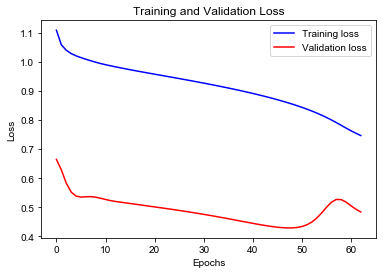

In [447]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [448]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return



2022-05-22 10:27:24.653585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:27:24.689864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 25ms/step


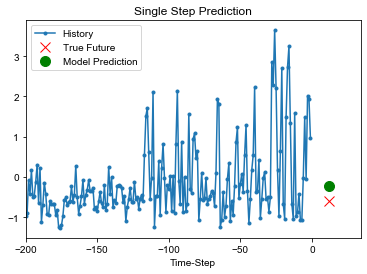

8/8 [==============================] - 0s 26ms/step


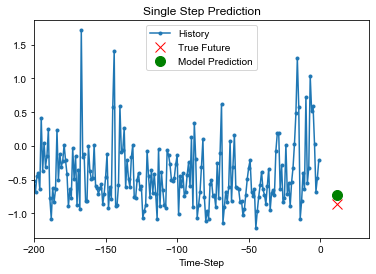

8/8 [==============================] - 0s 23ms/step


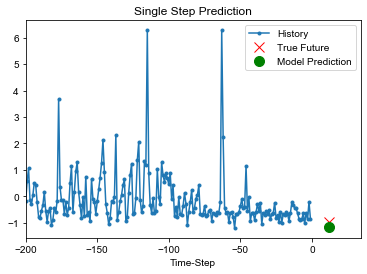

2022-05-22 10:27:25.885355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:27:25.924231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 450ms/step


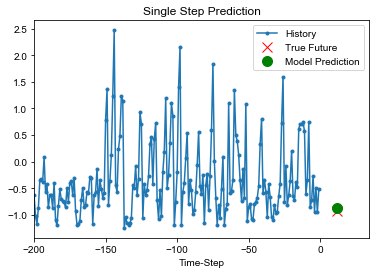

In [449]:
for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

2022-05-22 10:27:26.510323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-22 10:27:26.553618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 101ms/step


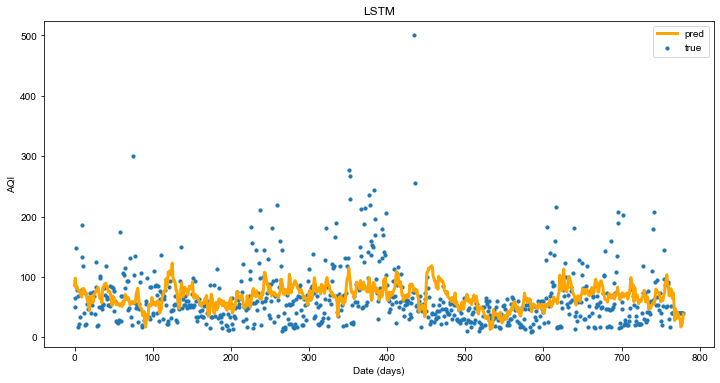

In [450]:
from sklearn.metrics import r2_score
pred = model.predict(dataset_val)
y_pred = y_scaler.inverse_transform(pred.reshape(-1,1))
y_true = y_scaler.inverse_transform(y_val.flatten()[-len(y_pred):].reshape(-1,1))
plt.figure(figsize=(12, 6))
plt.plot(y_pred,label = 'pred',color = 'orange',linewidth = 3)
plt.scatter(list(range(len(y_pred))),y_true,label='true',s=10)
plt.legend()
plt.title('LSTM')
plt.xlabel('Date (days)')
plt.ylabel('AQI')
plt.savefig('../time_series/pic/day/lstm_daily.png')



In [451]:
import sys
sys.path.append('../')
from metrics import calc_metric
calc_metric(y_true, y_pred,'LSTM').to_csv('../result/lstm_daily.csv')

In [452]:
model.save('./models/lstm_128_dense_1.h5')

7/7 [==============================] - 0s 66ms/step


Text(0.5, 1.0, 'r2_score:-0.2052')

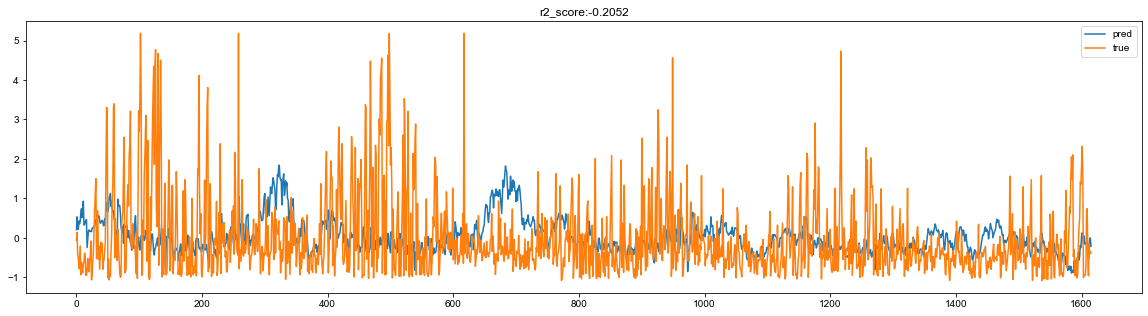

In [453]:
from sklearn.metrics import r2_score
pred = model.predict(dataset_train)
y_pred = pred
y_true = y_train.flatten()[-len(y_pred):]
plt.figure(figsize=(20, 5))
plt.plot(y_pred,label = 'pred')
plt.plot(y_true,label='true')
plt.legend()
plt.title('r2_score:{:.4f}'.format(r2_score(y_true,y_pred)))
